In [1]:
from qcodes import Parameter
from qcodes.dataset.plotting import plot_by_id
from pytopo.sweep import sweep, measure, call
from pytopo.qctools.dataset2 import do_experiment

In [2]:
x = Parameter("x", set_cmd=None, get_cmd=None)
y = Parameter("y", set_cmd=None, get_cmd=None)
m = Parameter("m", get_cmd=lambda: x.get()**2 + y.get())

Starting experimental run with id: 160
hello world
hello world
hello world


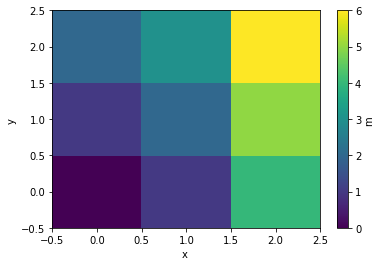

In [6]:
sweep_object = sweep(x, [0, 1, 2])(
    sweep(y, [0, 1, 2])(
        measure(m), 
    ), 
    call(print, "hello world")
)

setup = [lambda: None]
cleanup = [lambda: None]

experiment_result = do_experiment(setup, sweep_object, cleanup)
experiment_result.plot()

In [7]:
experiment_result["m"]

{'x': array([0, 0, 0, 1, 1, 1, 2, 2, 2]),
 'y': array([0, 1, 2, 0, 1, 2, 0, 1, 2]),
 'm': array([0, 1, 2, 1, 2, 3, 4, 5, 6])}